# Training Attempt 2


In [1]:
import os
from typing import List, Dict, Tuple
import functools

import librosa
import librosa.display
from librosa.core import load
import numpy as np
import IPython.display as ipd
import ipywidgets as ipw
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchaudio
torchaudio.set_audio_backend("sox_io")
import pandas as pd
from tqdm import tqdm

from beat2d import settings

/home/jason/miniconda3/envs/beat2d/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
DATASET_PATH = "../data/oneshots"
CLASSES = {"none": 0, "kick": 1, "snare": 2}

In [4]:
def play(path: str, sr: int = settings.SAMPLE_RATE):
    s, _ = load(path, sr)
    return ipd.Audio(s, rate=settings.SAMPLE_RATE)

# Dataset

## Loading the Dataset

In [5]:
df = pd.read_csv("../data/oneshots/_index.csv")

## Labelling the Data

In [6]:
df_labelled = df.copy()
df_labelled["label"] = pd.NA
df_labelled.head(20)

,id,oneshot,source,start,end,label
0,ZfQAfZA8CHgiVJ8mUk4MgQ,../data/oneshots/ZfQAfZA8CHgiVJ8mUk4MgQ.wav,../data/recordings/kicks.wav,2048,14336,<NA>
1,94Qe9qWPFpmWnZKZ9amPhQ,../data/oneshots/94Qe9qWPFpmWnZKZ9amPhQ.wav,../data/recordings/kicks.wav,14336,26112,<NA>
2,3vxjeNCuVyWSKgcwsgEKBp,../data/oneshots/3vxjeNCuVyWSKgcwsgEKBp.wav,../data/recordings/kicks.wav,26112,37888,<NA>
3,EvhJRVwhW8o6bTe9Nd7p3M,../data/oneshots/EvhJRVwhW8o6bTe9Nd7p3M.wav,../data/recordings/kicks.wav,37888,45056,<NA>
4,h8XDzg3SjdjhQNdCfvcTRu,../data/oneshots/h8XDzg3SjdjhQNdCfvcTRu.wav,../data/recordings/kicks.wav,45056,50176,<NA>
5,kNboCiCPeFP3CgffugXpEb,../data/oneshots/kNboCiCPeFP3CgffugXpEb.wav,../data/recordings/kicks.wav,50176,56832,<NA>
6,EgguwTMD2fSQCjm3HtDF72,../data/oneshots/EgguwTMD2fSQCjm3HtDF72.wav,../data/recordings/kicks.wav,56832,61440,<NA>
7,WnN8u5LnCsXHXMxhBs5DLe,../data/oneshots/WnN8u5LnCsXHXMxhBs5DLe.wav,../data/recordings/kicks.wav,61440,67584,<NA>
8,7wj6egXESf97w4ZUadivFQ,../data/oneshots/7wj6egXESf97w4ZUadivFQ.wav,../data/recordings/kicks.wav,67584,73216,<NA>
9,cisjSQHSn2L4tD7QEJ7r5L,../data/oneshots/cisjSQHSn2L4tD7QEJ7r5L.wav,../data/recordings/kicks.wav,73216,84480,<NA>


In [7]:
def label_step(df: pd.DataFrame, index=0, recursive=True, unlabelled_only=False):
    ipd.clear_output()

    if index - 1 >= df.oneshot.count():
        print("Done labelling")
        return
    
    if unlabelled_only and not pd.isna(df.label[index]):
        while not pd.isna(df.label[index]):
            index += 1
        label_step(df, index+1, recursive, unlabelled_only)
        return
    
    oneshot = df.oneshot[index]
    audio, sr = librosa.core.load(oneshot, settings.SAMPLE_RATE)
    
    print(f"index: {index}, id: {df.id[index]}, file: {oneshot}\nlabel: {df.label[index]}")

    ipd.display(ipd.Audio(audio, rate=settings.SAMPLE_RATE, autoplay=True))

    buttons = []
    
    back_btn = ipw.Button(description="back")
    back_btn.on_click(lambda _: label_step(df, index-1, recursive))
    buttons.append(back_btn)
    
    for cls in CLASSES:
        def cb(label, *args):
            df.loc[index, "label"] = label
            label_step(df, index+1)
        
        btn = ipw.Button(description=cls)
        btn.on_click(functools.partial(cb, cls))
        buttons.append(btn)
    
    next_btn = ipw.Button(description="next")
    next_btn.on_click(lambda _: label_step(df, index+1, recursive))
    buttons.append(next_btn)
    
    ipd.display(ipw.HBox(buttons))

In [8]:
label_step(df_labelled, unlabelled_only=True)

index: 0, id: ZfQAfZA8CHgiVJ8mUk4MgQ, file: ../data/oneshots/ZfQAfZA8CHgiVJ8mUk4MgQ.wav
label: <NA>


In [9]:
df_labelled.label.value_counts()

Series([], Name: label, dtype: int64)

In [10]:
# Commented so we don't overwrite it
# df_labelled.to_csv("../data/oneshots/_labels.csv")

In [11]:
dataset = pd.read_csv("../data/oneshots/_labels.csv")

First I want to take a look at the average length of samples.

In [12]:
dataset.length = dataset.oneshot.apply(lambda o: (
    librosa.get_duration(librosa.core.load(o, sr=settings.SAMPLE_RATE)[0], settings.SAMPLE_RATE)
))

/home/jason/miniconda3/envs/beat2d/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [13]:
dataset.length.describe()

count    249.000000
mean       0.526471
std        0.299361
min        0.069660
25%        0.325079
50%        0.487619
75%        0.603719
max        2.693515
Name: oneshot, dtype: float64

Text(0, 0.5, 'Number of Samples')

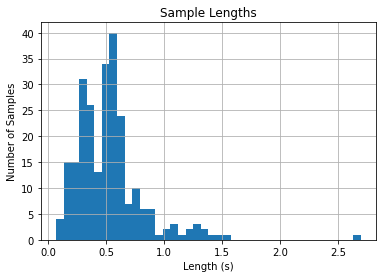

In [14]:
ax = dataset.length.hist(bins=40)
ax.set_title("Sample Lengths")
ax.set_xlabel("Length (s)")
ax.set_ylabel("Number of Samples")

# Computing Features

Next we'll use torchaudio to generate our features from the audio. I chose to use MEL Spectrograms to transform my data into another feature space.

In [15]:
def mel_spectrogram_layer(sr: int = settings.SAMPLE_RATE):
    return torchaudio.transforms.MelSpectrogram(
        sample_rate=sr,
        n_mels=70,
        normalized=True,
        n_fft=800
    )

def compute_features(sample: np.ndarray, sr: int = settings.SAMPLE_RATE):
    return mel_spectrogram_layer()(torch.from_numpy(sample))

Now I'll get a list of each track.

In [16]:
nones = dataset[dataset.label == "none"]
kicks = dataset[dataset.label == "kick"]
snares = dataset[dataset.label == "snare"]

/home/jason/miniconda3/envs/beat2d/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/jason/miniconda3/envs/beat2d/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Text(0.5, 1.0, 'snare')

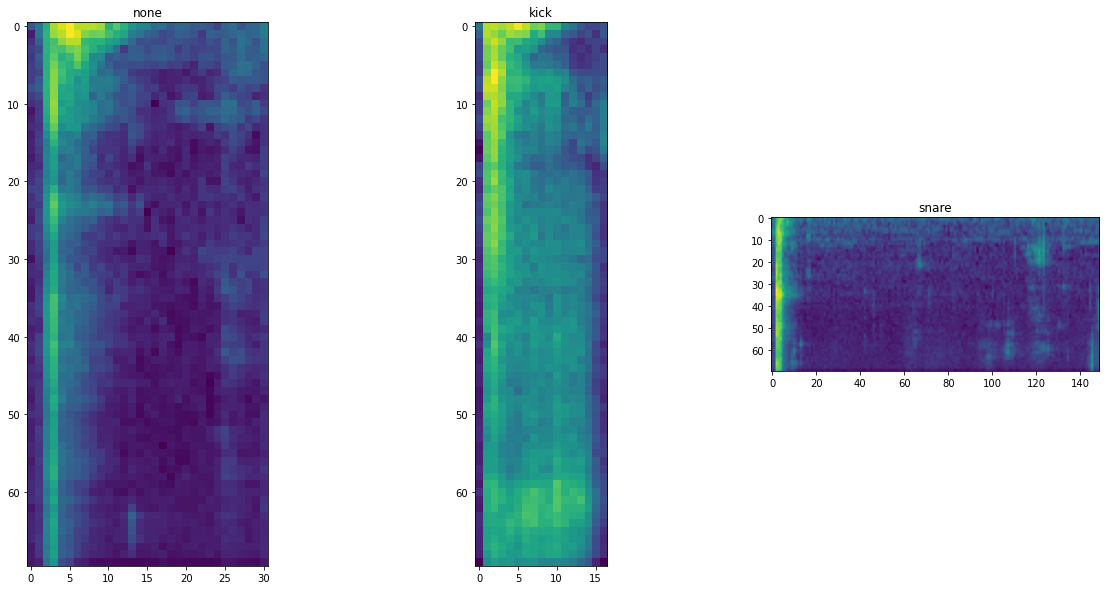

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))

s = load(nones.sample(1).iloc[0].oneshot, settings.SAMPLE_RATE)[0]
melspec = compute_features(s, settings.SAMPLE_RATE)
ax1.imshow(melspec.log2().detach().numpy())
ax1.set_title("none")
                                    
s = load(kicks.sample(1).iloc[0].oneshot, settings.SAMPLE_RATE)[0]
melspec = compute_features(s, settings.SAMPLE_RATE)
ax2.imshow(melspec.log2().detach().numpy())
ax2.set_title("kick")

s = load(snares.sample(1).iloc[0].oneshot, settings.SAMPLE_RATE)[0]
melspec = compute_features(s, settings.SAMPLE_RATE)
ax3.imshow(melspec.log2().detach().numpy())
ax3.set_title("snare")

A human could probably identify each type of sample using the Mel Spectrogram, so our model should be pretty good at it too!

# Preprocessing Data

There's a couple things we need to do to preprocess our data before our model sees it:

1. Normalize the audio sample
2. Trim the sample to relevant audio
3. Crop or pad the sample to 0.5 seconds (11025 samples)

In [18]:
# We'll use this sample for all our preprocessing steps
# idx = 30
# idx = 55
idx = 238

s = load(dataset.iloc[idx].oneshot, settings.SAMPLE_RATE)[0]

print(dataset.iloc[idx].label)

ipd.Audio(s, rate=settings.SAMPLE_RATE)

snare


## Normalizing

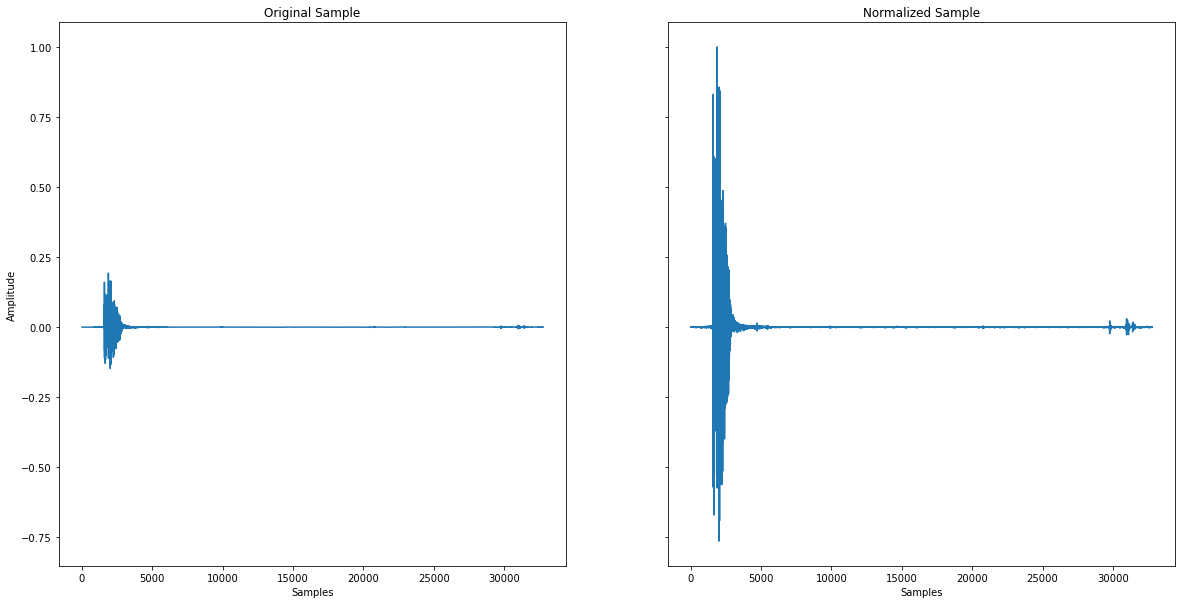

In [19]:
s_norm = librosa.util.normalize(s)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), sharey=True)

ax1.set_title("Original Sample")
ax1.set_ylabel("Amplitude")
ax1.set_xlabel("Samples")
ax1.plot(s)

ax2.set_title("Normalized Sample")
ax2.set_xlabel("Samples")
ax2.plot(s_norm)

## Trimming the Start and End

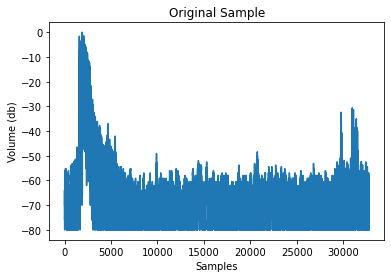

In [20]:
ax = plt.gca()

ax.set_title("Original Sample")
ax.set_ylabel("Volume (db)")
ax.set_xlabel("Samples")
ax.plot(librosa.core.amplitude_to_db(s_norm))

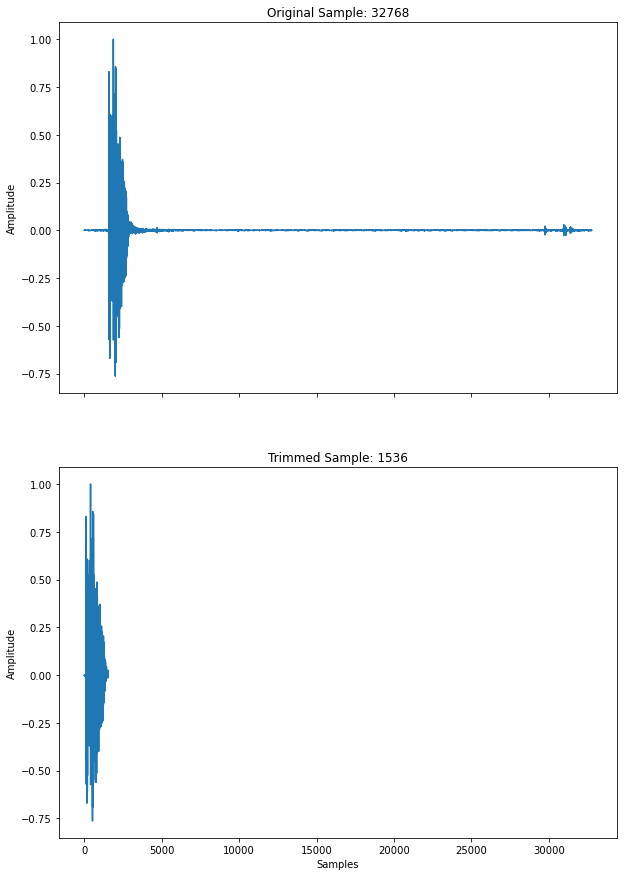

In [21]:
s_trim, trim_pts = librosa.effects.trim(s_norm, frame_length=256, hop_length=64, top_db=25)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 15), sharex=True)

ax1.set_title(f"Original Sample: {s_norm.shape[0]}")
ax1.set_ylabel("Amplitude")
ax1.plot(s_norm)

ax2.set_title(f"Trimmed Sample: {s_trim.shape[0]}")
ax2.set_ylabel("Amplitude")
ax2.set_xlabel("Samples")
ax2.plot(s_trim)

In [22]:
trimmed_lengths = dataset.oneshot.apply(lambda o: (
    librosa.get_duration(librosa.effects.trim(librosa.util.normalize(librosa.core.load(o, sr=settings.SAMPLE_RATE)[0]), frame_length=256, hop_length=64, top_db=20)[0], settings.SAMPLE_RATE)
))

In [23]:
trimmed_lengths.describe()

count    249.000000
mean       0.158646
std        0.150924
min        0.014512
25%        0.058050
50%        0.101587
75%        0.185760
max        0.743039
Name: oneshot, dtype: float64

<AxesSubplot:>

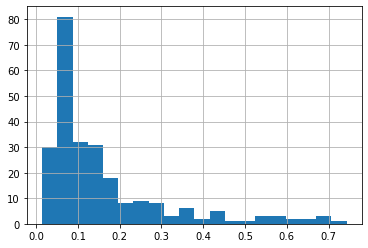

In [24]:
trimmed_lengths.hist(bins=20)

From this, I'm comfortable clipping at 0.2 seconds.

## Clipping and Padding to 0.2 Seconds

In [25]:
max_clip_length = librosa.core.time_to_samples(0.2)

In [26]:
s_dest = np.zeros(max_clip_length, dtype=np.float32)

clip_length = min(max_clip_length, s_trim.shape[0])
s_dest[:clip_length] = s_trim[:clip_length]

In [27]:
compute_features(s_dest).shape

torch.Size([70, 12])

torch.Size([70, 12])


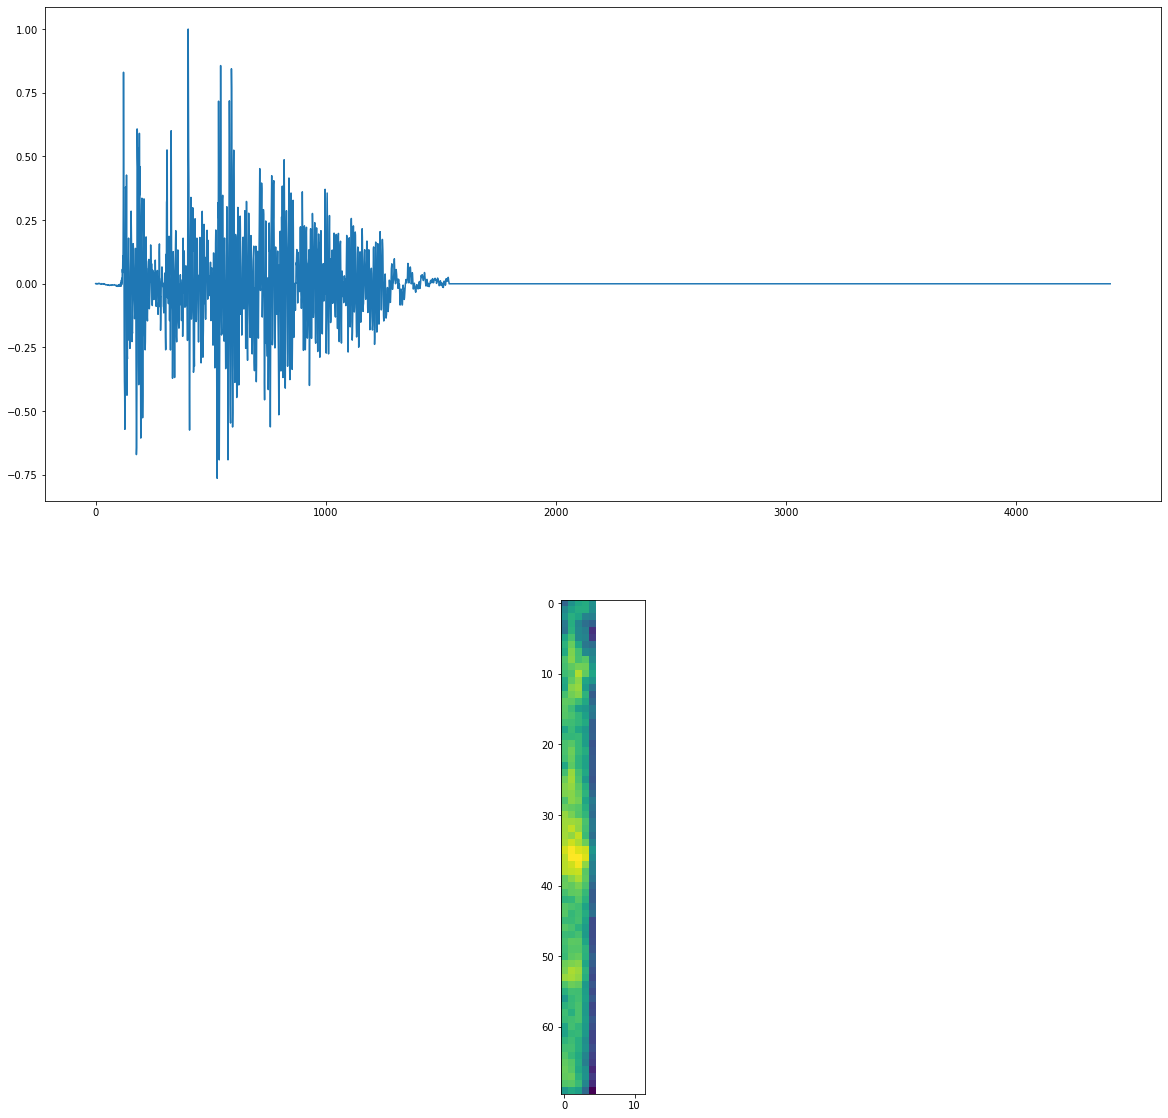

In [28]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))

melspec = compute_features(s_dest)
print(melspec.shape)

ax1.plot(s_dest)
ax2.imshow(melspec.log2().detach().numpy())

## Combining it into One Function

In [29]:
MAX_CLIP_LENGTH = librosa.core.time_to_samples(0.2)

def preprocess_sample(sample: np.ndarray):
    # Normalize the audio
    s_norm = librosa.util.normalize(sample)
    
    # Trim silence
    s_trim = librosa.effects.trim(s_norm, frame_length=256, hop_length=64, top_db=25)[0]
    
    # Clip or pad to MAX_CLIP_LENGTH
    s_dest = np.zeros(MAX_CLIP_LENGTH, dtype=np.float32)
    clip_length = min(MAX_CLIP_LENGTH, s_trim.shape[0])
    s_dest[:clip_length] = s_trim[:clip_length]
    
    return s_dest

MAX_CLIP_LENGTH2 = librosa.core.time_to_samples(0.4)

def preprocess_sample2(sample: np.ndarray):
    # Normalize the audio
    s_norm = librosa.util.normalize(sample)
    
    # Trim silence
    s_trim = librosa.effects.trim(s_norm, frame_length=256, hop_length=64, top_db=25)[0]
    
    # Clip or pad to MAX_CLIP_LENGTH
    s_dest = np.zeros(MAX_CLIP_LENGTH2, dtype=np.float32)
    clip_length = min(MAX_CLIP_LENGTH2, s_trim.shape[0])
    s_dest[:clip_length] = s_trim[:clip_length]
    
    return s_dest

In [30]:
MAX_CLIP_LENGTH2

8820

# Building our Model

In [44]:
class NetV1(nn.Module):

    def __init__(self):
        super().__init__()
        self.melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=settings.SAMPLE_RATE,
            n_mels=70,
            normalized=True
        )
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)

        self.fc1 = nn.Linear(16 * 16 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.melspec(x)
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 16 * 16 * 4)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.33)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x
    
    def predict(self, x):
        x = self.forward(x)
        
        return int(F.softmax(x, dim=1).argmax())
    

class NetV2(nn.Module):

    def __init__(self):
        super().__init__()
        self.melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=settings.SAMPLE_RATE,
            n_mels=128,
            n_fft=800,
            normalized=True
        )
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)

        self.fc1 = nn.Linear(16 * 30 * 4, 960)
        self.fc2 = nn.Linear(960, 480)
        self.fc3 = nn.Linear(480, 240)
        self.fc4 = nn.Linear(240, 3)

    def forward(self, x):
        x = self.melspec(x)
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 16 * 30 * 4)
        
        
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.2)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.2)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x
    
    def predict(self, x):
        x = self.forward(x)
        
        return int(F.softmax(x, dim=1).argmax())

In [45]:
16 * 30 * 4 / 2 / 2 /2/2/2

60.0

In [46]:
net = NetV2().to(device)

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.001)

# Preparing Training Data

In [48]:
class BeatboxDataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        row = self.df.iloc[idx]
        
        waveform = load(row.oneshot, settings.SAMPLE_RATE)[0]
        waveform = preprocess_sample(waveform)
        
        waveform_tensor = torch.from_numpy(waveform).view(1, 4410)
        
        return waveform_tensor.to(device), CLASSES[row.label]

    
class BeatboxDataset2(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        row = self.df.iloc[idx]
        
        waveform = load(row.oneshot, settings.SAMPLE_RATE)[0]
        waveform = preprocess_sample2(waveform)
        
        waveform_tensor = torch.from_numpy(waveform).view(1, 8820)
        
        return waveform_tensor.to(device), CLASSES[row.label]

In [49]:
train, test = train_test_split(dataset, test_size=0.25, shuffle=True)

In [50]:
train_set = BeatboxDataset2(train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)

test_set = BeatboxDataset2(test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=8)

In [51]:
data, label = next(iter(train_dataloader))

example_forward = net.forward(data[0].unsqueeze(0))

In [52]:
class Metric:
    def __init__(self, evaluation_func):
        self.evaluation_func = evaluation_func
        
        self.last = 0.0
        self.epoch_history = []
        self.history = []
        self.min = float('inf')
        self.max = 0.0
    
    def update(self, labels, predictions):
        val = float(self.evaluation_func(labels, predictions))
        self.epoch_history.append(val)
        
    def epoch_start(self):
        if len(self.epoch_history) > 0:
            epoch_val = np.mean(self.epoch_history)

            self.min = min(self.min, epoch_val)
            self.max = max(self.max, epoch_val)
            self.history.append(epoch_val)
            self.last = epoch_val

            self.epoch_history = []
        

class Evaluator:
    def __init__(self, metrics_dict):
        self.metrics = metrics_dict
    
    def update(self, labels, predictions):
        for metric in self.metrics.values():
            metric.update(labels, predictions)
    
    def epoch_start(self):
        for metric in self.metrics.values():
            metric.epoch_start()
    
    def metrics_string(self):
        output = ""
        for name, metric in self.metrics.items():
            output += f"{name}: {metric.last:04f} "
        return output
    

class EarlyStopping:
    def __init__(self, patience):
        self.patience = patience
        self.counter = 0
    
    def reset(self):
        self.counter = 0
    
    def should_stop(self):
        self.counter += 1
        if self.counter >= self.patience:
            return True
        return False

In [53]:
def train_epoch(dataloader: torch.utils.data.DataLoader, evaluator: Evaluator):
    total_loss = 0.0
    for batch_i, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        total_loss += loss.item()
        
        evaluator.update(labels.cpu(), outputs.cpu())
    
    return total_loss / len(dataloader)

In [54]:
epochs = 200
early_stop = EarlyStopping(10)

train_evaluator = Evaluator({
    "loss": Metric(lambda labels, preds: nn.CrossEntropyLoss()(preds, labels)),
    "acc": Metric(lambda labels, preds: metrics.accuracy_score(labels, [int(p.argmax()) for p in preds.detach().numpy()])),
    "prec": Metric(lambda labels, preds: metrics.precision_score(labels, [int(p.argmax()) for p in preds.detach().numpy()], average="weighted")),
    "recall": Metric(lambda labels, preds: metrics.recall_score(labels, [int(p.argmax()) for p in preds.detach().numpy()], average="weighted")),
    "f1": Metric(lambda labels, preds: metrics.f1_score(labels, [int(p.argmax()) for p in preds.detach().numpy()], average="weighted"))
})

val_evaluator = Evaluator({
    "loss": Metric(lambda labels, preds: nn.CrossEntropyLoss()(preds, labels)),
    "acc": Metric(lambda labels, preds: metrics.accuracy_score(labels, [int(p.argmax()) for p in preds.detach().numpy()])),
    "prec": Metric(lambda labels, preds: metrics.precision_score(labels, [int(p.argmax()) for p in preds.detach().numpy()], average="weighted")),
    "recall": Metric(lambda labels, preds: metrics.recall_score(labels, [int(p.argmax()) for p in preds.detach().numpy()], average="weighted")),
    "f1": Metric(lambda labels, preds: metrics.f1_score(labels, [int(p.argmax()) for p in preds.detach().numpy()], average="weighted"))
})

for i in range(epochs):
    print("Epoch", i)
    
    train_evaluator.epoch_start()
    
    net.train()
    train_loss = train_epoch(train_dataloader, train_evaluator)
    
    print(f"Training:  ", train_evaluator.metrics_string())
    
    net.eval()
    test_loss = 0.0
    
    val_evaluator.epoch_start()
    
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            
            loss = criterion(outputs, labels)
            
            val_evaluator.update(labels.cpu(), outputs.cpu())
            
    print(f"Validation:", val_evaluator.metrics_string())
    
    if val_evaluator.metrics["loss"].last > val_evaluator.metrics["loss"].min:
        if early_stop.should_stop():
            print("Early Stopping...")
            break
        else:
            early_stop.reset()
            torch.save(net.state_dict(), "model.pth")

Epoch 0


/home/jason/miniconda3/envs/beat2d/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training:   loss: 0.000000 acc: 0.000000 prec: 0.000000 recall: 0.000000 f1: 0.000000 
Validation: loss: 0.000000 acc: 0.000000 prec: 0.000000 recall: 0.000000 f1: 0.000000 
Epoch 1


/home/jason/miniconda3/envs/beat2d/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training:   loss: 1.093218 acc: 0.427083 prec: 0.322080 recall: 0.427083 f1: 0.325233 
Validation: loss: 1.080923 acc: 0.526786 prec: 0.500893 recall: 0.526786 f1: 0.503915 
Epoch 2
Training:   loss: 1.076774 acc: 0.552083 prec: 0.478410 recall: 0.552083 f1: 0.483813 
Validation: loss: 1.048855 acc: 0.540179 prec: 0.520833 recall: 0.540179 f1: 0.512574 
Epoch 3
Training:   loss: 1.030926 acc: 0.562500 prec: 0.448053 recall: 0.562500 f1: 0.474965 
Validation: loss: 0.977954 acc: 0.571429 prec: 0.455102 recall: 0.571429 f1: 0.489953 
Epoch 4
Training:   loss: 0.950323 acc: 0.598958 prec: 0.509654 recall: 0.598958 f1: 0.523808 
Validation: loss: 0.929471 acc: 0.602679 prec: 0.553832 recall: 0.602679 f1: 0.564103 
Epoch 5
Training:   loss: 0.852888 acc: 0.609375 prec: 0.546267 recall: 0.609375 f1: 0.541552 
Validation: loss: 0.862281 acc: 0.604911 prec: 0.579464 recall: 0.604911 f1: 0.573803 
Epoch 6
Training:   loss: 0.749290 acc: 0.713542 prec: 0.697780 recall: 0.713542 f1: 0.668446 
Val

Training:   loss: 0.035643 acc: 0.994792 prec: 0.996094 recall: 0.994792 f1: 0.994643 
Validation: loss: 2.383075 acc: 0.758929 prec: 0.809524 recall: 0.758929 f1: 0.771023 
Epoch 47
Training:   loss: 0.036041 acc: 0.989583 prec: 0.993490 recall: 0.989583 f1: 0.990334 
Validation: loss: 2.062943 acc: 0.823661 prec: 0.849702 recall: 0.823661 f1: 0.828017 
Epoch 48
Training:   loss: 0.024220 acc: 0.994792 prec: 1.000000 recall: 0.994792 f1: 0.997024 
Validation: loss: 2.345746 acc: 0.792411 prec: 0.834077 recall: 0.792411 f1: 0.800933 
Epoch 49
Training:   loss: 0.028542 acc: 0.994792 prec: 0.996094 recall: 0.994792 f1: 0.994643 
Validation: loss: 2.194979 acc: 0.808036 prec: 0.860714 recall: 0.808036 f1: 0.815278 
Epoch 50
Training:   loss: 0.048857 acc: 0.979167 prec: 0.983941 recall: 0.979167 f1: 0.978902 
Validation: loss: 2.193378 acc: 0.774554 prec: 0.825149 recall: 0.774554 f1: 0.786648 
Epoch 51
Training:   loss: 0.031507 acc: 0.984375 prec: 0.988715 recall: 0.984375 f1: 0.983892

Training:   loss: 0.006868 acc: 1.000000 prec: 1.000000 recall: 1.000000 f1: 1.000000 
Validation: loss: 2.365150 acc: 0.792411 prec: 0.841890 recall: 0.792411 f1: 0.802307 
Epoch 92
Training:   loss: 0.007040 acc: 1.000000 prec: 1.000000 recall: 1.000000 f1: 1.000000 
Validation: loss: 2.355912 acc: 0.776786 prec: 0.836682 recall: 0.776786 f1: 0.788954 
Epoch 93
Training:   loss: 0.007856 acc: 1.000000 prec: 1.000000 recall: 1.000000 f1: 1.000000 
Validation: loss: 2.134827 acc: 0.823661 prec: 0.849702 recall: 0.823661 f1: 0.828017 
Epoch 94
Training:   loss: 0.005466 acc: 1.000000 prec: 1.000000 recall: 1.000000 f1: 1.000000 
Validation: loss: 2.253309 acc: 0.792411 prec: 0.841890 recall: 0.792411 f1: 0.802307 
Epoch 95
Training:   loss: 0.005008 acc: 1.000000 prec: 1.000000 recall: 1.000000 f1: 1.000000 
Validation: loss: 2.201740 acc: 0.808036 prec: 0.841890 recall: 0.808036 f1: 0.816369 
Epoch 96
Training:   loss: 0.004999 acc: 1.000000 prec: 1.000000 recall: 1.000000 f1: 1.000000

Training:   loss: 0.004883 acc: 1.000000 prec: 1.000000 recall: 1.000000 f1: 1.000000 
Validation: loss: 2.701625 acc: 0.776786 prec: 0.834077 recall: 0.776786 f1: 0.788433 
Epoch 137
Training:   loss: 0.004406 acc: 1.000000 prec: 1.000000 recall: 1.000000 f1: 1.000000 
Validation: loss: 2.699972 acc: 0.776786 prec: 0.826265 recall: 0.776786 f1: 0.789286 
Epoch 138
Training:   loss: 0.006773 acc: 1.000000 prec: 1.000000 recall: 1.000000 f1: 1.000000 
Validation: loss: 2.612743 acc: 0.792411 prec: 0.836682 recall: 0.792411 f1: 0.803017 
Epoch 139
Training:   loss: 0.008080 acc: 1.000000 prec: 1.000000 recall: 1.000000 f1: 1.000000 
Validation: loss: 2.831260 acc: 0.792411 prec: 0.836682 recall: 0.792411 f1: 0.803017 
Epoch 140
Training:   loss: 0.005273 acc: 1.000000 prec: 1.000000 recall: 1.000000 f1: 1.000000 
Validation: loss: 2.832362 acc: 0.776786 prec: 0.826265 recall: 0.776786 f1: 0.789286 
Epoch 141
Training:   loss: 0.004850 acc: 1.000000 prec: 1.000000 recall: 1.000000 f1: 1.0

Training:   loss: 0.003608 acc: 1.000000 prec: 1.000000 recall: 1.000000 f1: 1.000000 
Validation: loss: 2.958027 acc: 0.761161 prec: 0.802827 recall: 0.761161 f1: 0.771767 
Epoch 182
Training:   loss: 0.003618 acc: 1.000000 prec: 1.000000 recall: 1.000000 f1: 1.000000 
Validation: loss: 2.947950 acc: 0.745536 prec: 0.792411 recall: 0.745536 f1: 0.758036 
Epoch 183
Training:   loss: 0.003549 acc: 1.000000 prec: 1.000000 recall: 1.000000 f1: 1.000000 
Validation: loss: 2.976489 acc: 0.761161 prec: 0.823661 recall: 0.761161 f1: 0.774702 
Epoch 184
Training:   loss: 0.003041 acc: 1.000000 prec: 1.000000 recall: 1.000000 f1: 1.000000 
Validation: loss: 3.021958 acc: 0.761161 prec: 0.802827 recall: 0.761161 f1: 0.771767 
Epoch 185
Training:   loss: 0.003581 acc: 1.000000 prec: 1.000000 recall: 1.000000 f1: 1.000000 
Validation: loss: 2.984223 acc: 0.761161 prec: 0.802827 recall: 0.761161 f1: 0.771767 
Epoch 186
Training:   loss: 0.004050 acc: 1.000000 prec: 1.000000 recall: 1.000000 f1: 1.0

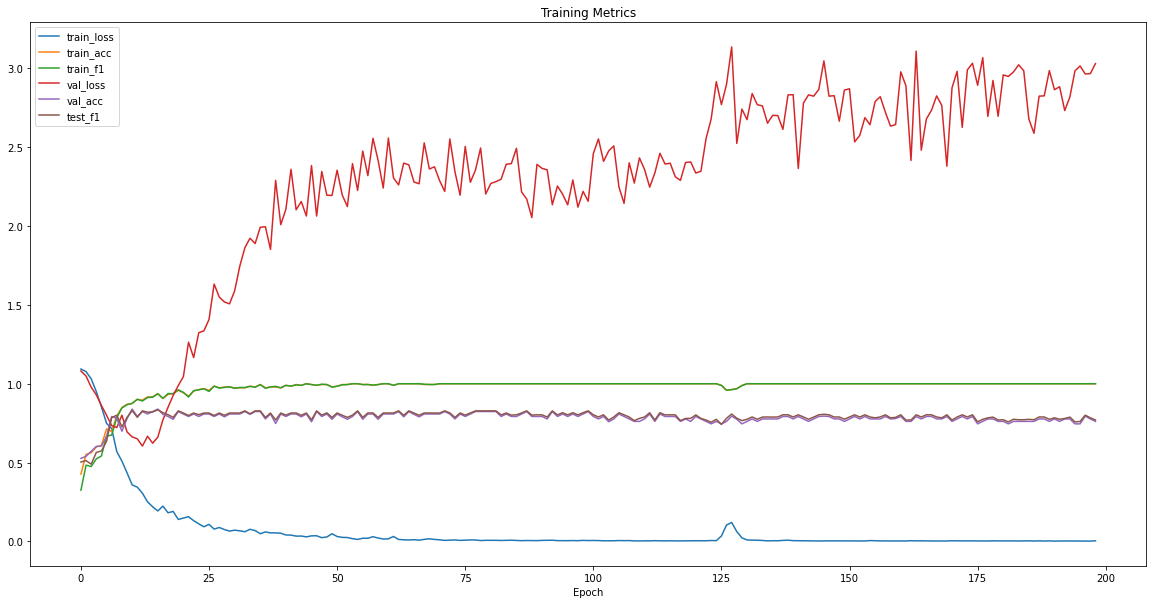

In [55]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.set_facecolor("white")

ax.set_title("Training Metrics")
ax.set_xlabel("Epoch")

ax.plot(train_evaluator.metrics["loss"].history, label="train_loss")
ax.plot(train_evaluator.metrics["acc"].history, label="train_acc")
ax.plot(train_evaluator.metrics["f1"].history, label="train_f1")

ax.plot(val_evaluator.metrics["loss"].history, label="val_loss")
ax.plot(val_evaluator.metrics["acc"].history, label="val_acc")
ax.plot(val_evaluator.metrics["f1"].history, label="test_f1")

ax.legend()

In [ ]:
# torch.save(net.state_dict(), "../models/model.pth")

In [ ]:
# To load into memory
# model = Net()
# model.load_state_dict(torch.load("../models/model.pth"))
# model.eval()

# Testing our Final Model

In [ ]:
from beat2d import model

In [ ]:
m = model.load_model()

In [ ]:
dataset.loc[dataset.id == "Q7gFWKMVBsFBQ47WW5qhFA"]

In [ ]:
def predict_play_random_example(df: pd.DataFrame, m: model.Model, label: str, sr: int = settings.SAMPLE_RATE):
    ex = test[test.label == label].sample(1).iloc[0]
    
    X, sr = load(ex.oneshot, settings.SAMPLE_RATE)

    pred = m.predict(X)

    print(ex.id, pred, ex.label)

    ipd.display(ipd.Audio(X, rate=settings.SAMPLE_RATE))

In [ ]:
predict_play_random_example(test, m, "none")

In [ ]:
predict_play_random_example(test, m, "kick")

In [ ]:
predict_play_random_example(test, m, "snare")

# Testing with iPhone Recordings

Using a totally different microphone and environment, I want to see if our model can handle the change in data.

The main steps we have to go to go from recording to MIDI are:

1. Split the audio by onsets
2. Predict the class of each oneshot
3. Transform the timestamp, amplitude, and label information to MIDI

In [401]:
from beat2d import slicing

In [ ]:
m = model.load_model()

In [399]:
s, sr = load("../data/test/iphone01.m4a", settings.SAMPLE_RATE)
ipd.Audio(s, rate=sr)

/home/jason/miniconda3/envs/beat2d/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [402]:
slices, slice_pts = slicing.split_oneshots(s, sr)

In [406]:
for slc in slices:
    pred = net.predict(slc)
    print(pred)
    ipd.display(ipd.Audio(slc, rate=sr))
    input()
    ipd.clear_output()

(4608,)


TypeError: 'int' object is not callable

In [ ]:
s, sr = load("../data/test/iphone02.m4a", settings.SAMPLE_RATE, )
ipd.display(ipd.Audio(s, rate=sr))

slices, slice_pts = slicing.split_oneshots(s, sr)

In [ ]:
for slc in slices:
    pred = m.predict(slc)
    print(pred)
    ipd.display(ipd.Audio(slc, rate=sr))
    input()
    ipd.clear_output()